In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [117]:
stock_list = ["2317","2330","3008"]
# for i in ["2317","2330","3008"]:
df = pd.DataFrame()

# for i in ["2317"]:
for i in stock_list:

    StockData = pd.read_csv("C:\\Users\\Terry\\Downloads\\stock_portfolio\\"+i+".csv",header=None)
    StockData = StockData[[0,6]]
#     交易日期、成交股數、成交金額、開盤價、最高價、最低價、收盤價、漲跌價差、成交筆數
    StockData[0] = (StockData[0].str.split("/",expand=True)[0].astype(int)+1911).astype(str)+"/"+StockData[0].str.split("/",expand=True)[1]+"/"+StockData[0].str.split("/",expand=True)[2]      
    StockData.columns = ["Date","Close"]
    datetime_format = '%Y%m%d %H:%M:%S'
    StockData["Date"] = pd.to_datetime(StockData["Date"],format=datetime_format)     
#     StockData.columns = ["date","open_interest","volume","open","high","low","close","漲跌價差","成交筆數","datetime"]
#     StockData = StockData[["datetime","open","high","low","close","volume","open_interest"]]
    # type(StockData["volume"].iloc[0])

    StockData["Close"] = StockData["Close"].replace("--",np.nan)
    StockData["Close"] = StockData["Close"].astype(float)
    StockData = StockData[(StockData["Date"]>"2015") & (StockData["Date"]<"2017")]
    StockData.index = StockData["Date"]
    StockData["return"] = StockData.Close.pct_change().fillna(0)
    df = pd.concat([df,StockData["return"]],axis=1)

df.columns = stock_list
    

In [118]:
df.head()

,2317,2330,3008
2015-01-05,0.000000,0.000000,0.000000
2015-01-06,-0.030963,-0.043011,-0.031915
2015-01-07,0.008284,0.003745,0.010989
2015-01-08,0.019953,0.029851,0.028261
2015-01-09,-0.004603,-0.028986,-0.010571


In [119]:
from functools import reduce

df = df[1:]
returns = df
covariance_matrix = returns.cov() * 252
# covariance_matrix
stocks_expected_return = returns.mean() * 252
stocks_weights = np.array([(1/len(stock_list)) for i in range(len(stock_list))])
portfolio_return = sum(stocks_weights * stocks_expected_return)
portfolio_risk = np.sqrt(reduce(np.dot, [stocks_weights, covariance_matrix, stocks_weights.T]))
# portfolio_risk = np.sqrt(np.dot(np.dot(stocks_weights, covariance_matrix),stocks_weights.T))
# portfolio_risk
# r = sum(w * mean)
# var = np.dot(w, cov)
# var = np.dot(sds, w.T)
# s = np.sqrt(var) # s = var ** .5

print('投資組合預期報酬率為: '+ str(round(portfolio_return,4)))
print('投資組合風險為: ' + str(round(portfolio_risk,4)))


投資組合預期報酬率為: 0.1766
投資組合風險為: 0.2471


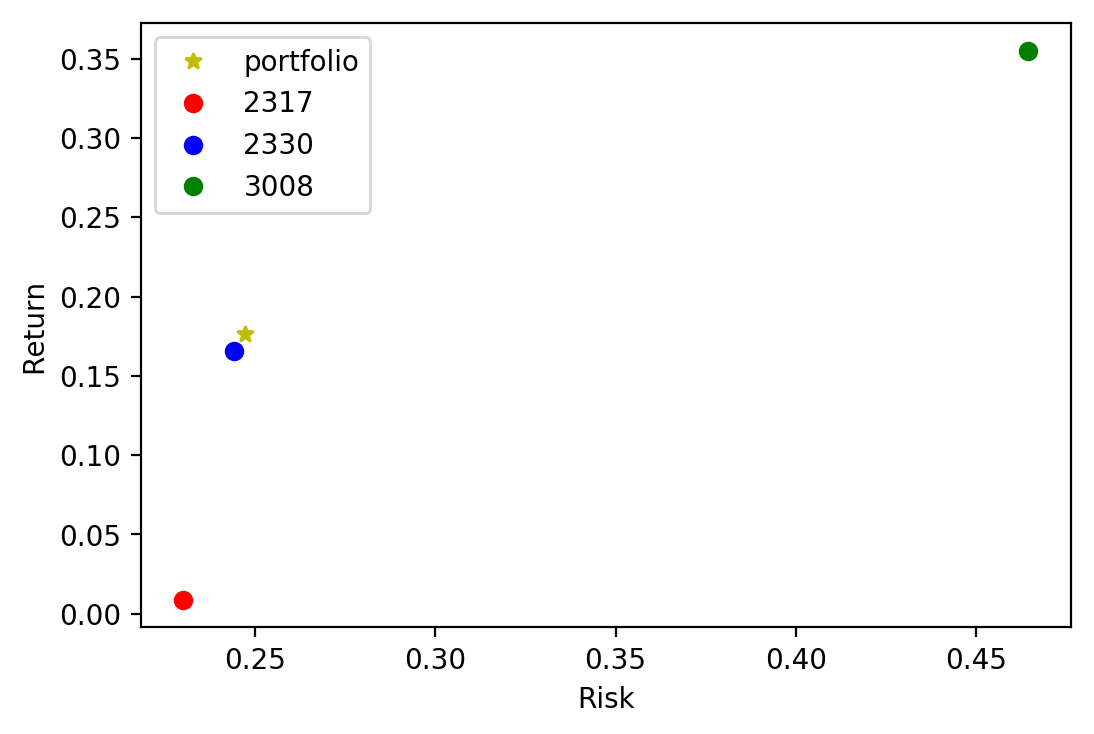

In [120]:
plt.figure(dpi=200)
plt.plot(portfolio_risk,portfolio_return ,'y*',label="portfolio")
plt.plot(np.sqrt(np.var(returns["2317"])*252) ,stocks_expected_return[0] ,'ro',label="2317")
plt.plot(np.sqrt(np.var(returns["2330"])*252) ,stocks_expected_return[1] ,'bo',label="2330")
plt.plot(np.sqrt(np.var(returns["3008"])*252) ,stocks_expected_return[2] ,'go',label="3008")

plt.xlabel("Risk")
plt.ylabel("Return")
plt.legend()

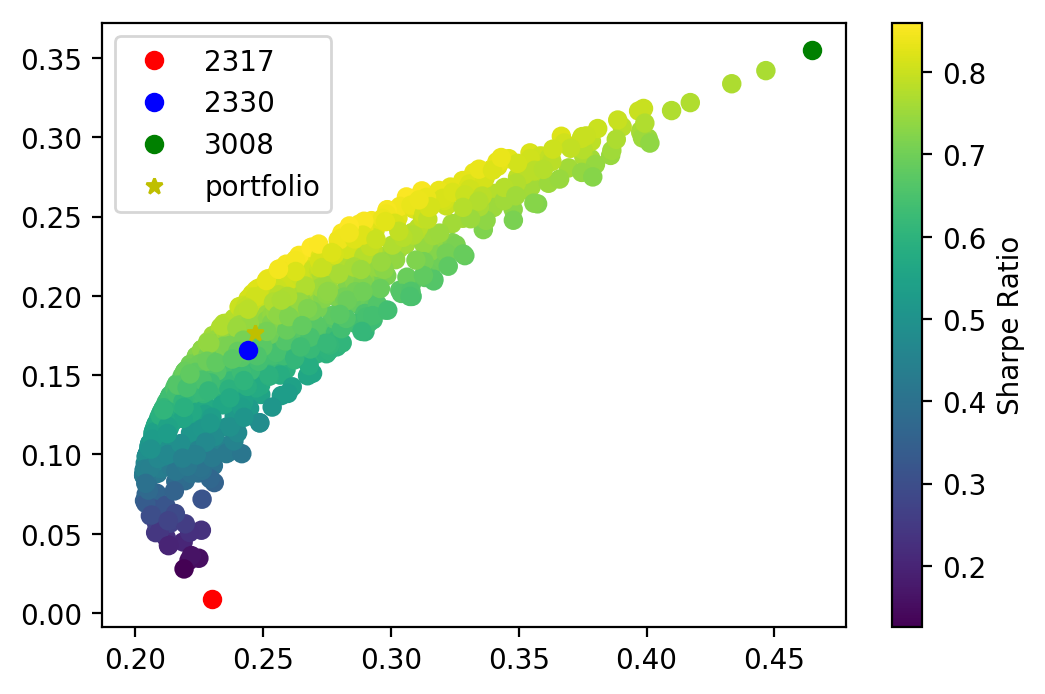

In [121]:
sds = []
rtn = []
stock_len = len(stock_list)
plt.figure(dpi=200)
for _ in range(1000):
    w = np.random.rand(stock_len)
    w /= sum(w)
    rtn.append(sum(stocks_expected_return * w))
    sds.append(np.sqrt(reduce(np.dot, [w, covariance_matrix, w.T])))
    

sc = plt.scatter(sds, rtn, c=(np.array(rtn))/np.array(sds)) # ro for red dot

plt.colorbar(sc, label = 'Sharpe Ratio')
plt.plot(np.sqrt(np.var(returns["2317"])*252) ,stocks_expected_return[0] ,'ro',label="2317")
plt.plot(np.sqrt(np.var(returns["2330"])*252) ,stocks_expected_return[1] ,'bo',label="2330")
plt.plot(np.sqrt(np.var(returns["3008"])*252) ,stocks_expected_return[2] ,'go',label="3008")
plt.plot(portfolio_risk,portfolio_return ,'y*',label="portfolio")

plt.legend()


In [122]:
#最佳化
import scipy.optimize as solver


In [123]:
# 最佳化目標函數 (最小化以下目標)

# weight餵入，計算風險
def std(w):
    return np.sqrt(reduce(np.dot, [w, covariance_matrix, w.T]))

# weight餵入，計算夏普
#因為最佳化時是以"最小化"為目標，所以若要求"最大化"夏普比率下的weight 則要加個"負"號
def sharpe(w):
    return  -1*(sum(stocks_expected_return * w)) / (np.sqrt(reduce(np.dot, [w, covariance_matrix, w.T])))

# weight餵入，計算報酬
# 因為最佳化時是以"最小化"為目標，所以若要求"最大化"報酬下的weight 則要加個"負"號
def ret(w):
    return -1*sum(stocks_expected_return * w)

In [124]:


def Opt_Weight(_iReturn):
    x0 = np.array([1.0 / stock_len for x in range(stock_len)])
    bounds = tuple((0, 1) for x in range(stock_len))
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: sum(x * stocks_expected_return) - _iReturn}]

    outcome = solver.minimize(std, x0=x0, constraints=constraints, bounds=bounds)
    return outcome
print("最佳化權重為:",Opt_Weight(.18).x)


最佳化權重為: [0.13746882 0.67390561 0.18862557]


In [125]:
print("投資組合的收益率是否等於0.18: ",sum(Opt_Weight(.18).x * stocks_expected_return))

投資組合的收益率是否等於0.18:  0.17999999999407912


In [126]:
# 使用numpy中的arange()函數，設定所有給定收益率在圖中顯示的0.18到0.26之間，每隔0.005記數一次。
given_r = np.arange(.04, .36, .005)


In [127]:
def Calculate_Return_or_Risk(w):
    return [(sum(stocks_expected_return * w)),np.sqrt(reduce(np.dot, [w, covariance_matrix, w.T]))]


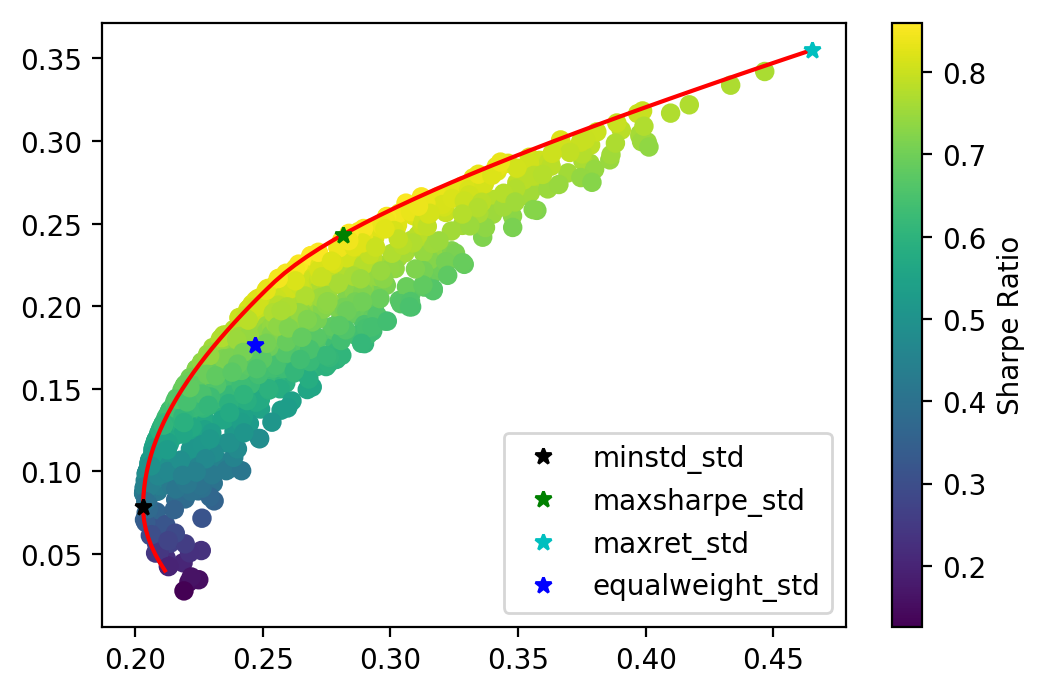

In [128]:

plt.figure(dpi=200)

#最佳化時的初始化權重
x0 = np.array([1.0 / stock_len for x in range(stock_len)])
bounds = tuple((0, 1) for x in range(stock_len))

risk = []
for i in given_r:
    risk.append(Opt_Weight(i).fun)

    
    

sc = plt.scatter(sds, rtn, c=(np.array(rtn))/np.array(sds)) # ro for red dot

plt.colorbar(sc, label = 'Sharpe Ratio')
plt.plot(risk, given_r, '-',color="red")


#最小化風險
constraints = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
min_weight =  solver.minimize(std, x0=x0, constraints=constraints, bounds=bounds).x
minstd_std = Calculate_Return_or_Risk(min_weight)[1]
minstd_ret = Calculate_Return_or_Risk(min_weight)[0]
minStd_return = returns*min_weight

plt.plot(minstd_std, min_ret, '*',color="black",label = "minstd_std") # w* for white star

#最大化夏普
constraints = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
maxsharpe_weight = solver.minimize(sharpe, x0=x0, constraints=constraints, bounds=bounds).x
maxsharpe_std = Calculate_Return_or_Risk(maxsharpe_weight)[1]
maxsharpe_ret = Calculate_Return_or_Risk(maxsharpe_weight)[0]
maxSharpe_return = returns*maxsharpe_weight
plt.plot(maxsharpe_std, maxsharpe_ret, 'g*',label = "maxsharpe_std") # w* for green star


#最大化報酬
constraints = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
maxreturn_weight =  solver.minimize(ret, x0=x0, constraints=constraints, bounds=bounds).x
maxret_std = Calculate_Return_or_Risk(maxreturn_weight)[1]
maxret_ret = Calculate_Return_or_Risk(maxreturn_weight)[0]
maxRet_return = returns*maxreturn_weight
plt.plot(maxret_std, maxret_ret, 'c*',label = "maxret_std") # w* for white star



#均等分配
equalWeight_return = returns*x0
plt.plot(portfolio_risk, portfolio_return,'b*',label = "equalweight_std")


plt.legend()


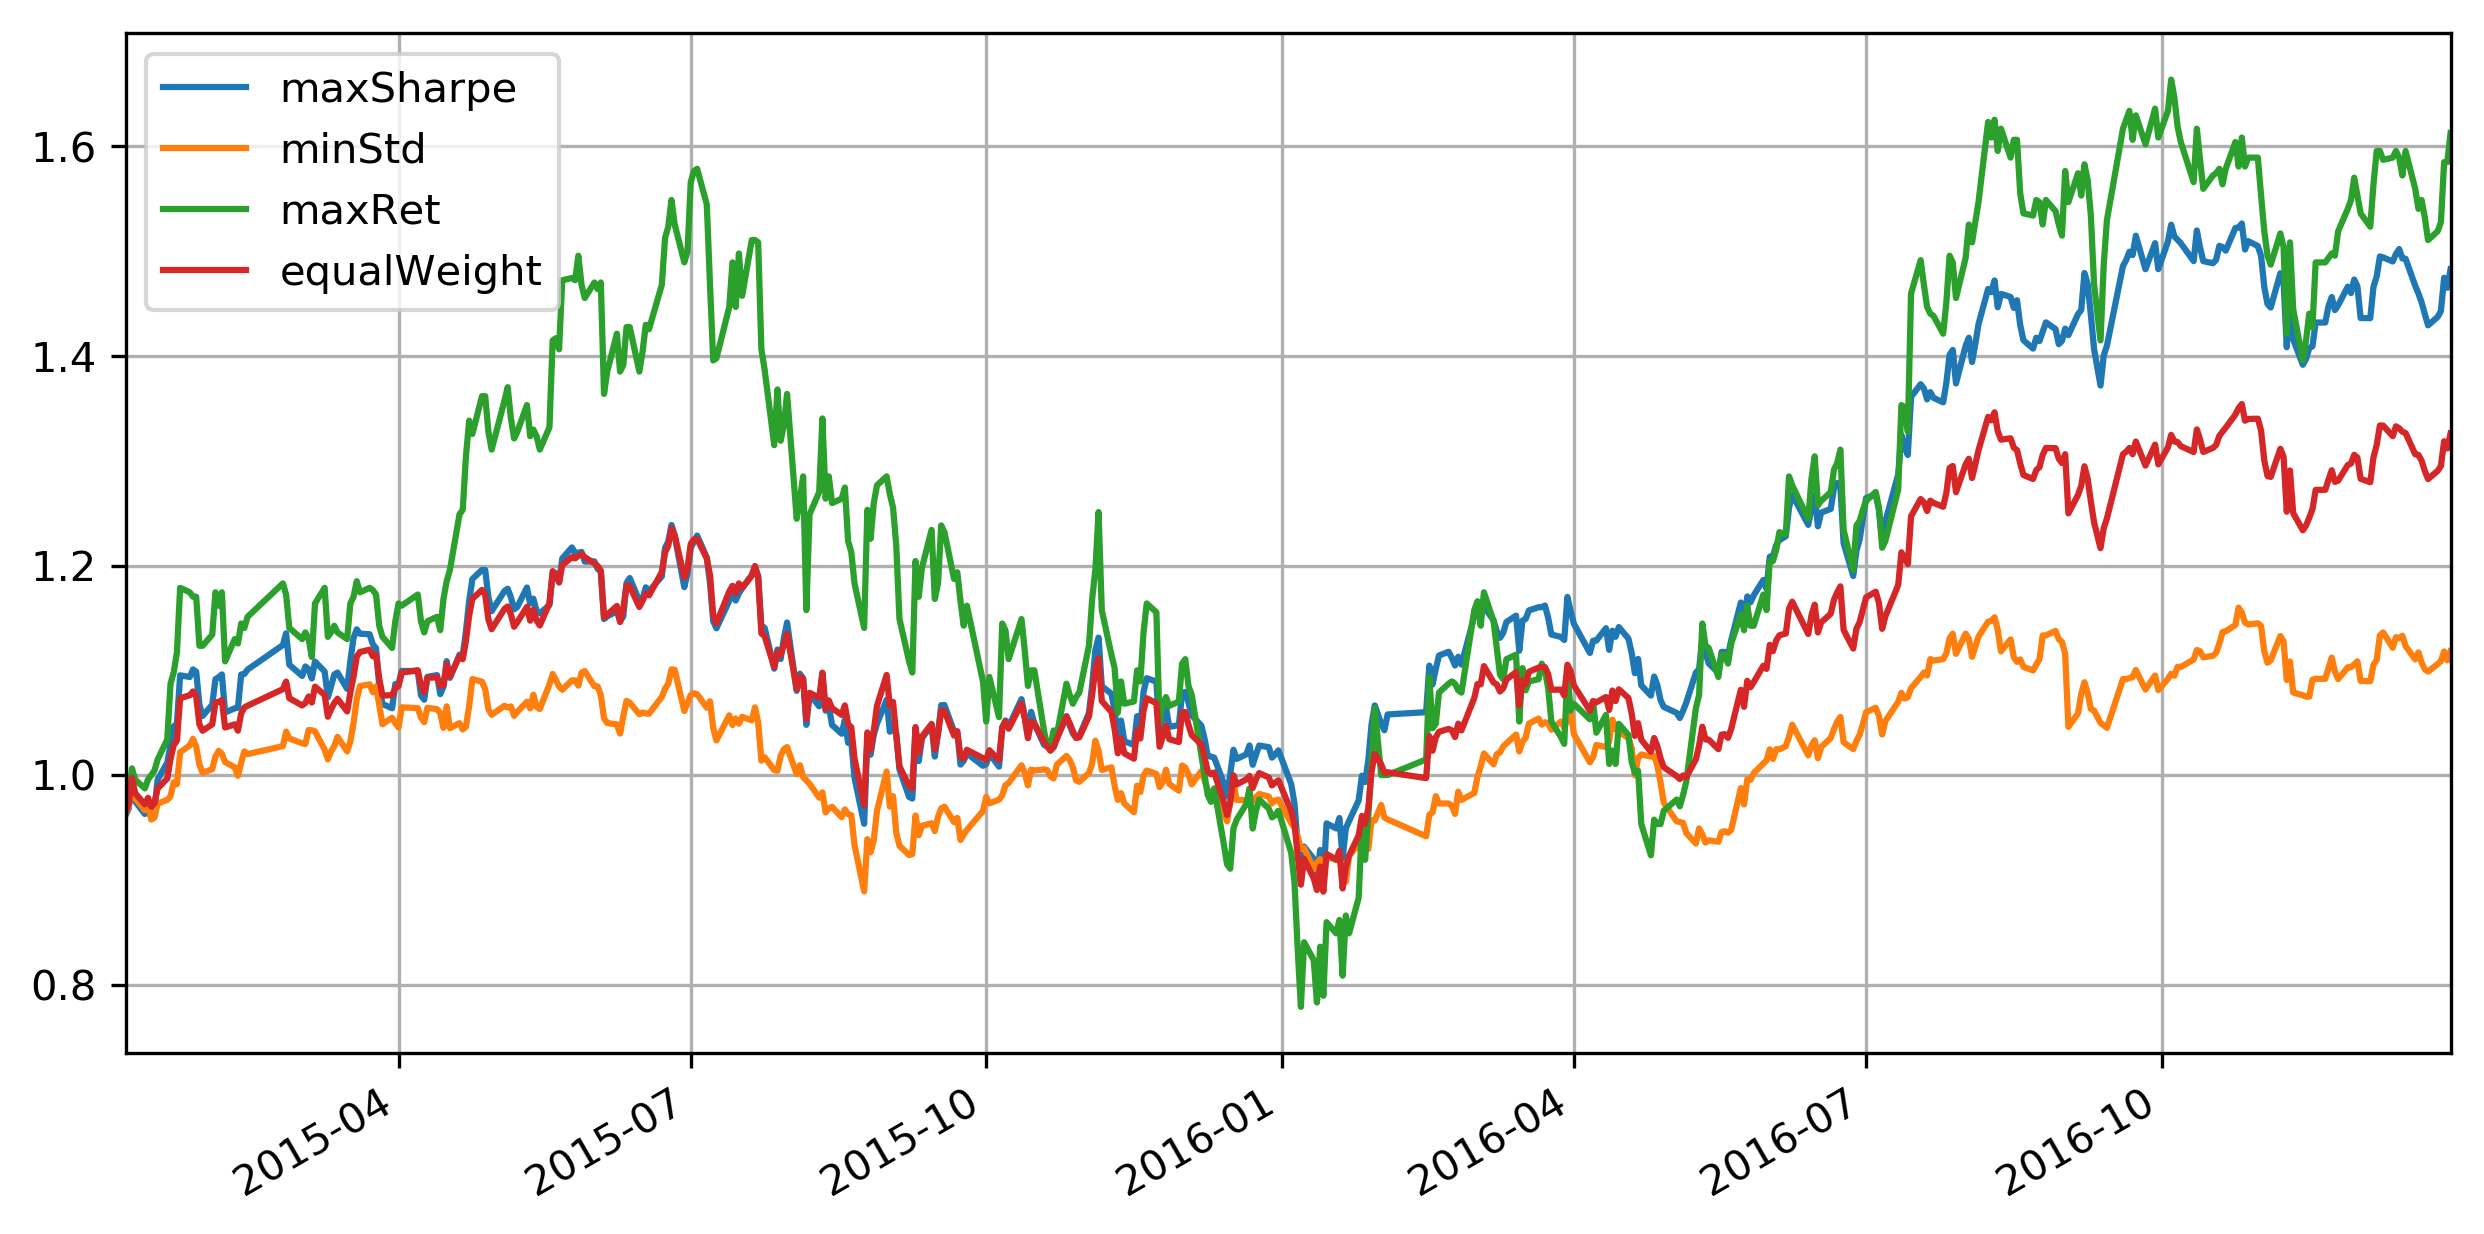

In [129]:
plt.figure(dpi = 300,figsize=(10,5))
(maxSharpe_return.sum(axis=1)+1).cumprod().plot(label = "maxSharpe")
(minStd_return.sum(axis=1)+1).cumprod().plot(label = "minStd")
(maxRet_return.sum(axis=1)+1).cumprod().plot(label = "maxRet")
(equalWeight_return.sum(axis=1)+1).cumprod().plot(label = "equalWeight")
plt.legend(loc="upper left")
plt.grid()